#### **Fixed Radius Particle Access Example**:

Example notebook to access all DM particles within 

In [3]:
import numpy as np
import illustris_python as il
import matplotlib.colors as colors
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle
import seaborn as sns
import h5py
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from colossus.halo import profile_nfw
from colossus.cosmology import cosmology as colossus_cosmo
from colossus.halo import concentration
import emcee
import scipy
import sys

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

sns.set(style = "ticks")
from IPython.core.display import display, HTML

%config IPCompleter.greedy = True
%config InlineBackend.figure_format ='retina'


basePath = '../Splashback-Research/TNG-300_3/outputs/'
snap_dir = basePath+'snapdir_099/snap_099.0.hdf5'

snapshot_ind = 99

# Load header file and halo group catalog
header = il.groupcat.loadHeader(basePath, snapshot_ind)
halo_grp_fields = ['GroupCM', 'GroupMass', 'Group_M_Crit200', 'Group_M_Mean200', 
                   'Group_R_Crit200', 'Group_R_Mean200', 'GroupFirstSub']
halo_grp = il.groupcat.loadHalos(basePath, snapshot_ind, fields=halo_grp_fields)


# Obtain basic cosmological info and obtain conversion factors
redshift = header['Redshift']
H = cosmo.H(redshift)
H0 = cosmo.H(0)
h = H0.value/100
cosmo_col = colossus_cosmo.setCosmology('planck15');

# Define box boundary vector in Mpc (for period bcs)
boxsize = header['BoxSize'] # kpc/h
box_bounds = boxsize*np.ones(3)/1000

# Get DM Particle mass
with h5py.File(snap_dir) as f:
    snap = dict(f['Header'].attrs.items())

dm_part_mass = snap['MassTable'][1]*10**10/h

#### **Pick Subset of Halos to Analyze**:

Specify a subset of halos from TNG-100_3 and TNG-100_3_Dark catalogs to perform analysis on.

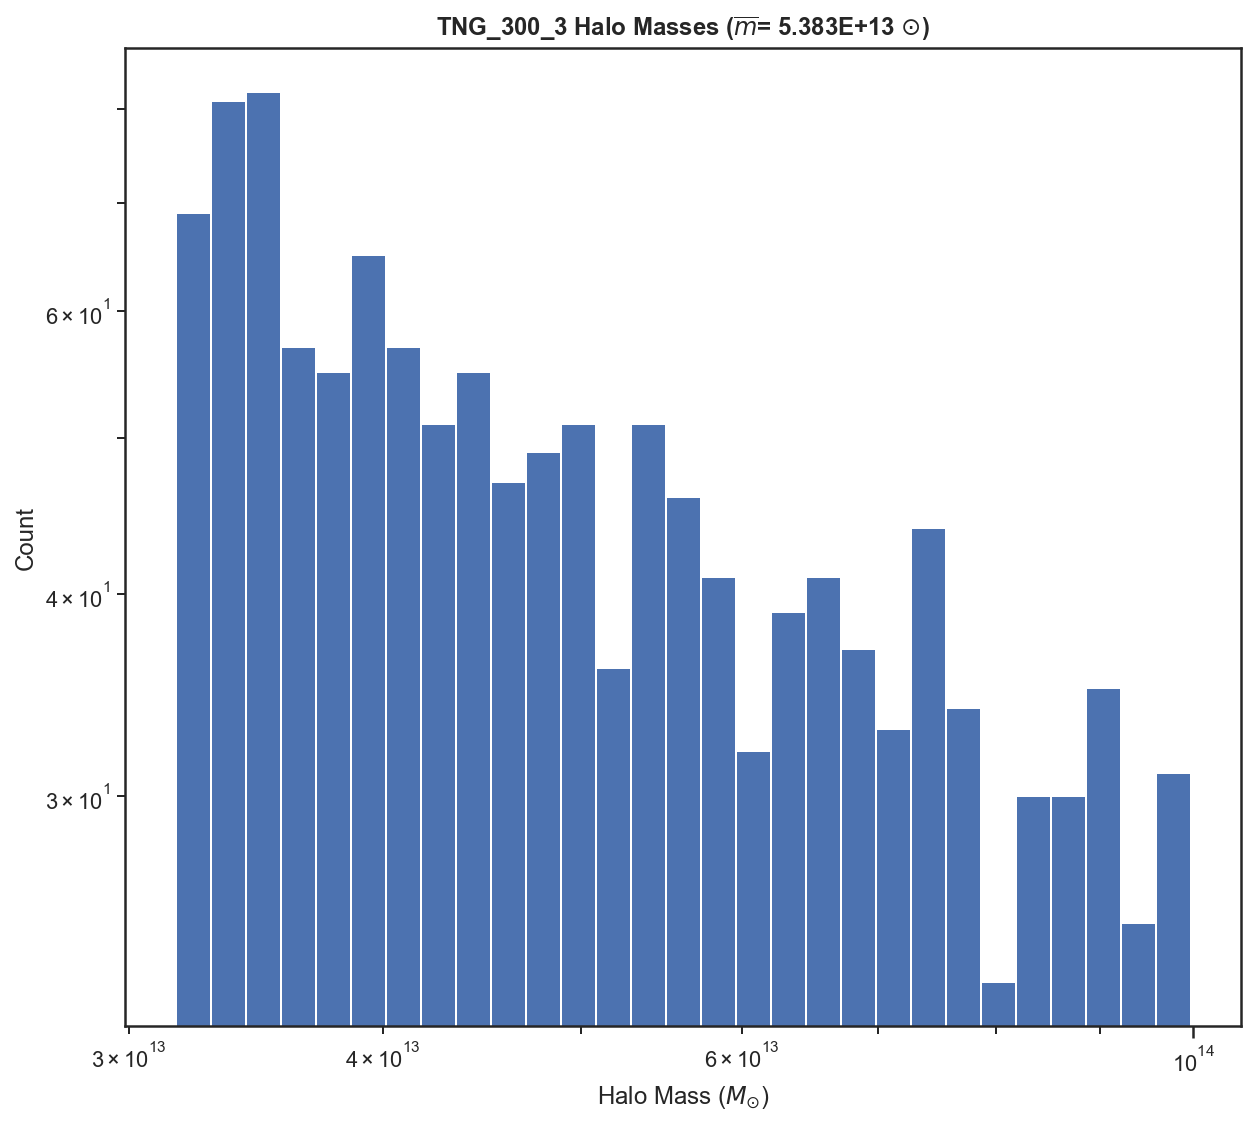

In [4]:
# get all profiles with halo mass between 10^13.5-10^14 solar mass in baryonic catalog
halo_masses = halo_grp['GroupMass']*10**10/h
halo_indices = np.where((halo_masses >= 10**13.5) & 
                        (halo_masses <= 10**14))[0]

plt.figure(figsize=(10, 9))


bins = np.logspace(np.min(np.log10(halo_masses[halo_indices])), 
                   np.max(np.log10(halo_masses[halo_indices])), 30)

plt.hist(halo_masses[halo_indices], bins=bins)
title_str = r"TNG_300_3 Halo Masses ($\overline{m}$= "
title_str += ("{:.3E} $\odot$)").format(np.mean(halo_masses[halo_indices]))
plt.title(title_str, fontweight="bold")
plt.xlabel(r"Halo Mass ($M_{\odot}$)")
plt.ylabel("Count")
plt.xscale("log")
plt.yscale("log")

##### **Load Particle Data (Dark):**

Load all dark matter particles within 2 Mpc of halo CM.

In [ ]:
def progress_bar(cur_val, final_val):
    """ 
    Function to keep track of progress during computations by displaying
    a progress bar

    Parameters:
    cur_val (int/float): current iteration/value calculation is on
    final_val (int/float): final iteration/value that calculation will take
    """

    bar_length = 20
    percent = float(cur_val) / final_val
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rProgress: [{0}]"
                     " {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [ ]:
# Load all DM particle coordinates within the snapshot

fields = ['Coordinates']
dm_coords_chunk = il.snapshot.loadSubset(basePath, snapshot_ind, "dm", fields, sq=True)/1000

In [ ]:
HALO_COUNT = len(halo_indices)
R_HALO = 2 # The maximum radius to collect particles about halo_cm (Mpc/h)
halo_dm_coords = np.empty(HALO_COUNT, dtype=object)

for i, halo_ind in enumerate(halo_indices[0:10]):
    
    progress_bar(i, HALO_COUNT)
    
    halo_cm = halo_grp['GroupCM'][halo_ind]/1000

    # Speed up radius calculations by eliminating all particles outside of a box of +-R of halo_cm
    box_filt = np.where((dm_coords_chunk.T[0] >= halo_cm[0]-R_HALO) & 
                      (dm_coords_chunk.T[0] <= halo_cm[0]+R_HALO) &
                      (dm_coords_chunk.T[1] >= halo_cm[1]-R_HALO) &
                      (dm_coords_chunk.T[1] <= halo_cm[1]+R_HALO) &
                      (dm_coords_chunk.T[2] >= halo_cm[2]-R_HALO) &
                      (dm_coords_chunk.T[2] <= halo_cm[2]+R_HALO)
                       )[0]
    
    dm_coords_filt = dm_coords_chunk[box_filt]
    
    # Compute radius from cm
    dev = dm_coords_filt-halo_cm

    # Account for halos which go over the boundary
    for ind, q in enumerate(dev.T):
        q = np.where(np.abs(q) > 0.5 * box_bounds[ind], box_bounds[ind]-np.abs(q), q)
        dev.T[ind] = q

    # Keep only particles within r = 2 Mpc/h
    r = np.linalg.norm(dev, axis=1)  
    halo_dm_coords[i] = dm_coords_chunk[np.where(r < R_HALO)]
    
    progress_bar(i+1, HALO_COUNT)

# Save output to a numpy array locally
np.save("../Splashback-Research/TNG-300_3/outputs/full_positions_099/dm_coods_examp.npy", halo_dm_coords)    